In [1]:
import scanpy as sc
import anndata as ad
import celltypist
from celltypist import models

In [20]:
sample1 = sc.read_10x_mtx('data/Case1-YF')
sample2 = sc.read_10x_mtx('data/Case1-ZY')


print("Sample1 shape:", sample1.shape)  # (n_cells, n_genes)
print("Sample2 shape:", sample2.shape)  # (n_cells, n_genes)

Sample1 shape: (21560, 33538)
Sample2 shape: (13685, 33538)


In [21]:
import scanpy as sc

for ad in (sample1, sample2):
    ad.var['mt'] = ad.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True)

    # filter on gene counts and percent-mito
    sc.pp.filter_cells(ad, min_genes=200)
    sc.pp.filter_cells(ad, max_genes=6000)
    ad = ad[ad.obs.pct_counts_mt < 15, :]
    sc.pp.filter_genes(ad, min_cells=3)


In [40]:
import scanpy as sc

# the **list** of AnnData objects goes first
adata = sc.concat(
    [sample1, sample2],         # <-- wrap in a list!
    label='tissue',             # name of the new obs column
    keys=['Tumor','Metastasis'],# values assigned to that column
    join='inner'                # keep only genes present in all
)


In [41]:
# Normalize and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# after your normalization & log1p, but before HVG or scaling, store for later
adata.raw = adata.copy()



In [51]:
# create a mask of non-mito genes
non_mito = ~adata.var_names.str.startswith('MT-')

# subset adata (both raw and X)
adata = adata[:, non_mito]
adata.raw = adata  # reset raw to match

# now rerun your rank_genes_groups
sc.tl.rank_genes_groups(
    adata,
    groupby='tissue',
    reference='Metastasis',
    method='wilcoxon',
    use_raw=True
)


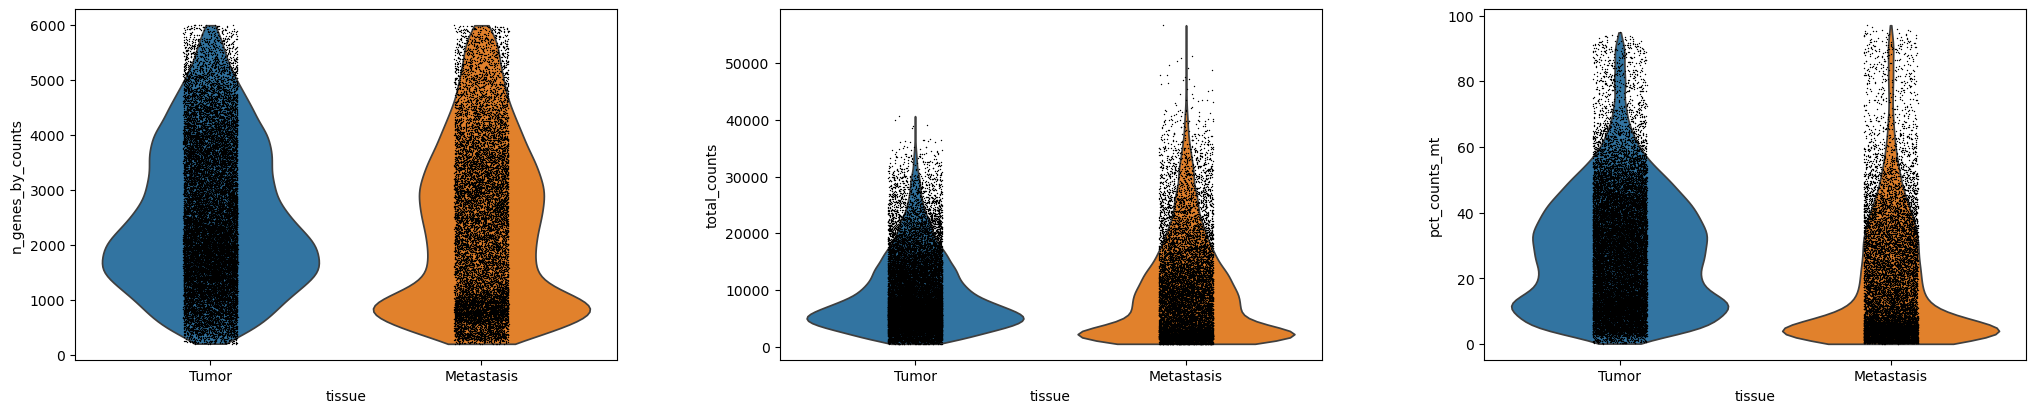

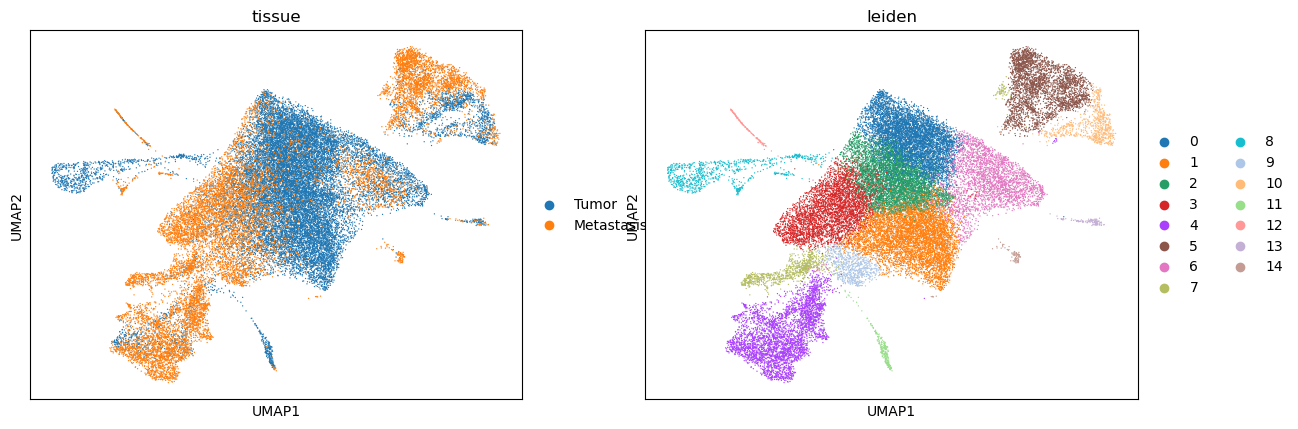

In [52]:
# 5) Scale, PCA, neighborhood graph, UMAP, clustering
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# 6) QC and embedding plots
sc.pl.violin(
    adata,
    ['n_genes_by_counts','total_counts','pct_counts_mt'],
    groupby='tissue',
    multi_panel=True
)
sc.pl.umap(adata, color=['tissue','leiden'])

# 7) Save for downstream
adata.write_h5ad('results/combined_all_samples2.h5ad')


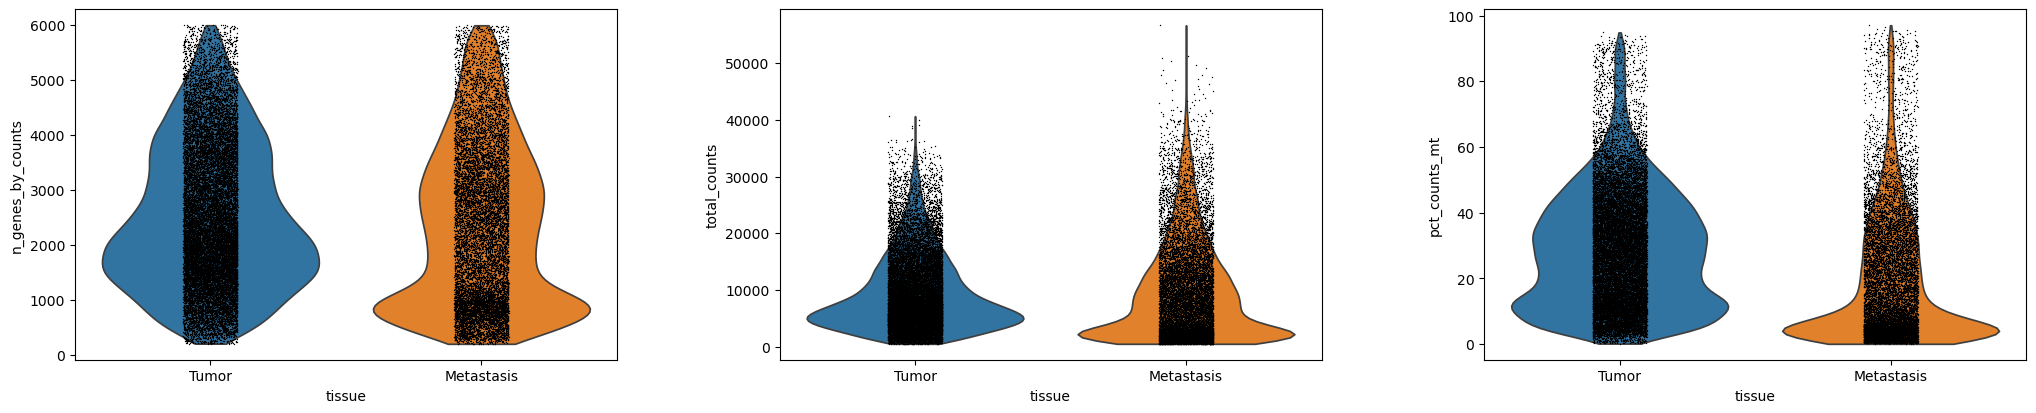

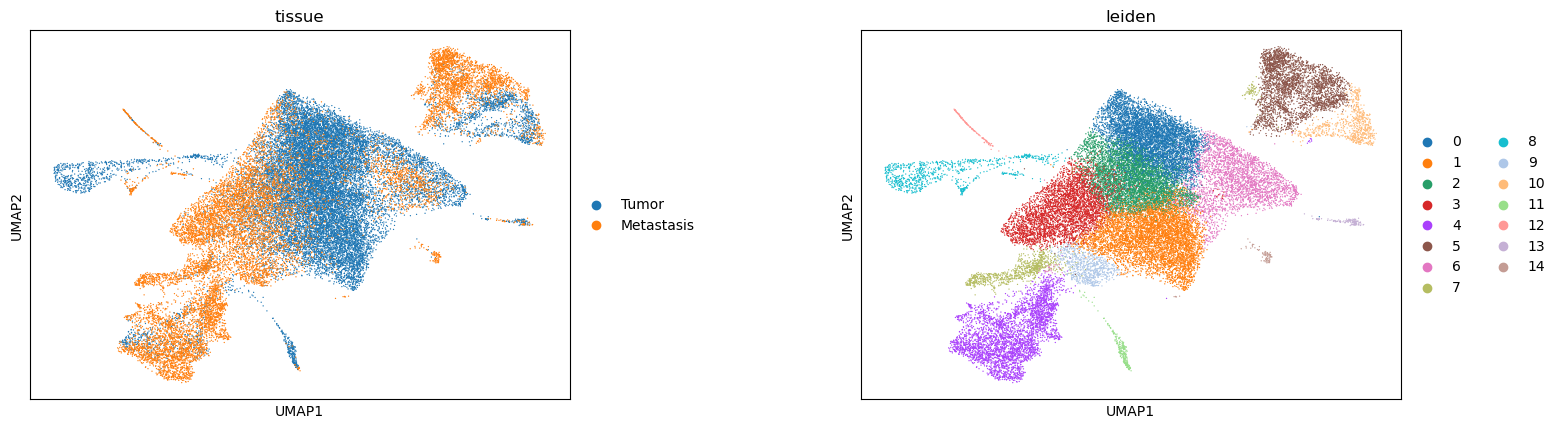

Written to results/combined_all_samples_scaled.h5ad


In [55]:
# 5) PCA → neighbors → UMAP → Leiden clustering
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# 6) Quick QC‐and‐embedding plots
sc.pl.violin(
    adata,
    ['n_genes_by_counts','total_counts','pct_counts_mt'],
    groupby='tissue',
    multi_panel=True
)
sc.pl.umap(adata, color=['tissue','leiden'], wspace=0.4)

# 7) (Re)stash raw for DE, if you haven’t already
adata.raw = adata

# 8) Save your processed object
import os
os.makedirs('results', exist_ok=True)
adata.write_h5ad('results/combined_all_samples_scaled.h5ad')
print("Written to results/combined_all_samples_scaled.h5ad")


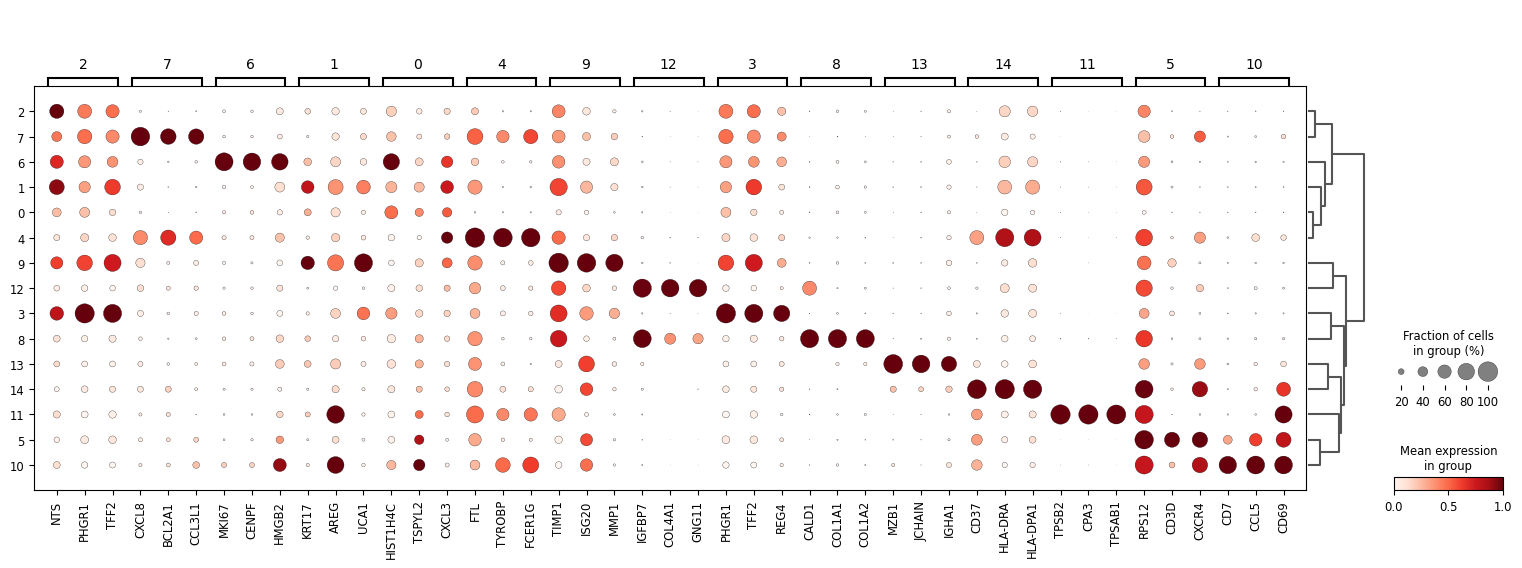

In [58]:
# Rank markers for each cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    use_raw=True
)

# Dotplot the top 3 per cluster
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=3,
    groupby='leiden',
    standard_scale='var',
    dendrogram=True
)


In [59]:
sc.tl.rank_genes_groups(
    adata,
    groupby='tissue',
    reference='Metastasis',
    method='wilcoxon',
    use_raw=True
)
sc.pl.rank_genes_groups_violin(
    adata,
    groupby='tissue',
    groups=['Tumor'],
    n_genes=5
)


TypeError: rank_genes_groups_violin() got an unexpected keyword argument 'groupby'

      names     scores  logfoldchanges         pvals     pvals_adj
0  HIST1H4C  19.938320             NaN  1.893185e-88  4.732964e-87
1    TSPYL2   6.809174             NaN  9.816100e-12  6.840488e-11
2     CXCL3   4.851400             NaN  1.225929e-06  7.086295e-06
3     KRT17   2.096564             NaN  3.603220e-02  1.344485e-01
4     IGLC2   1.515914             NaN  1.295412e-01  4.192271e-01


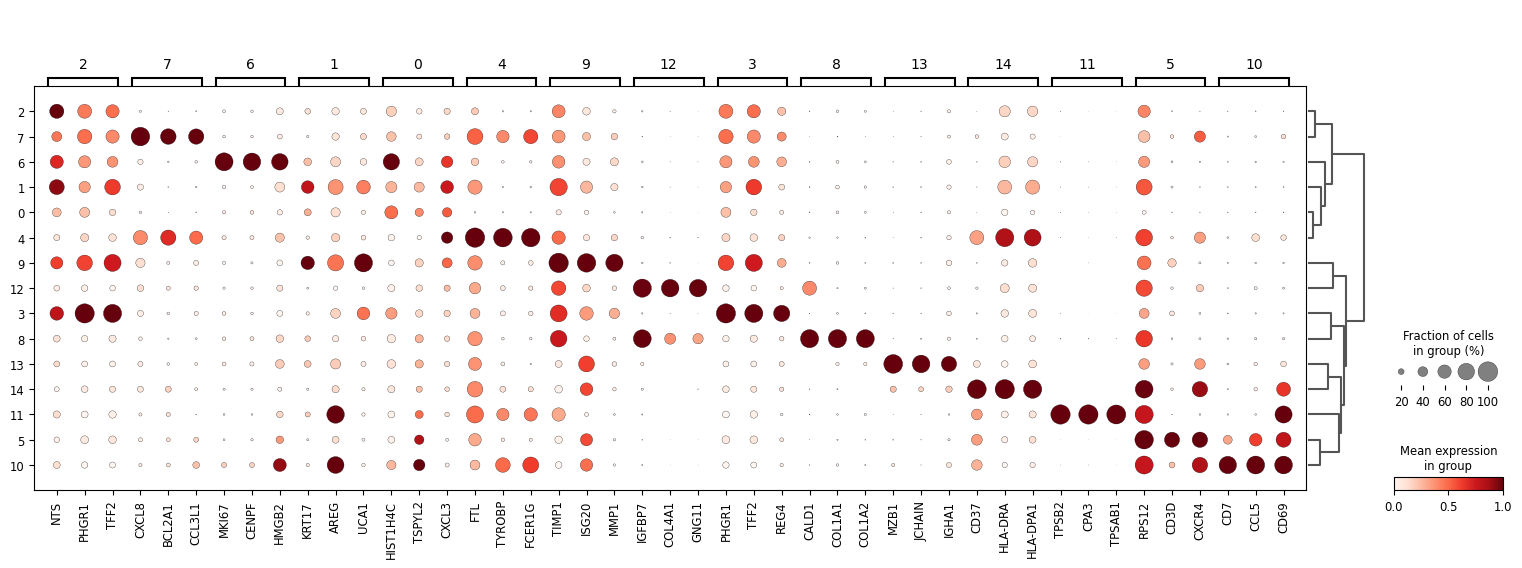

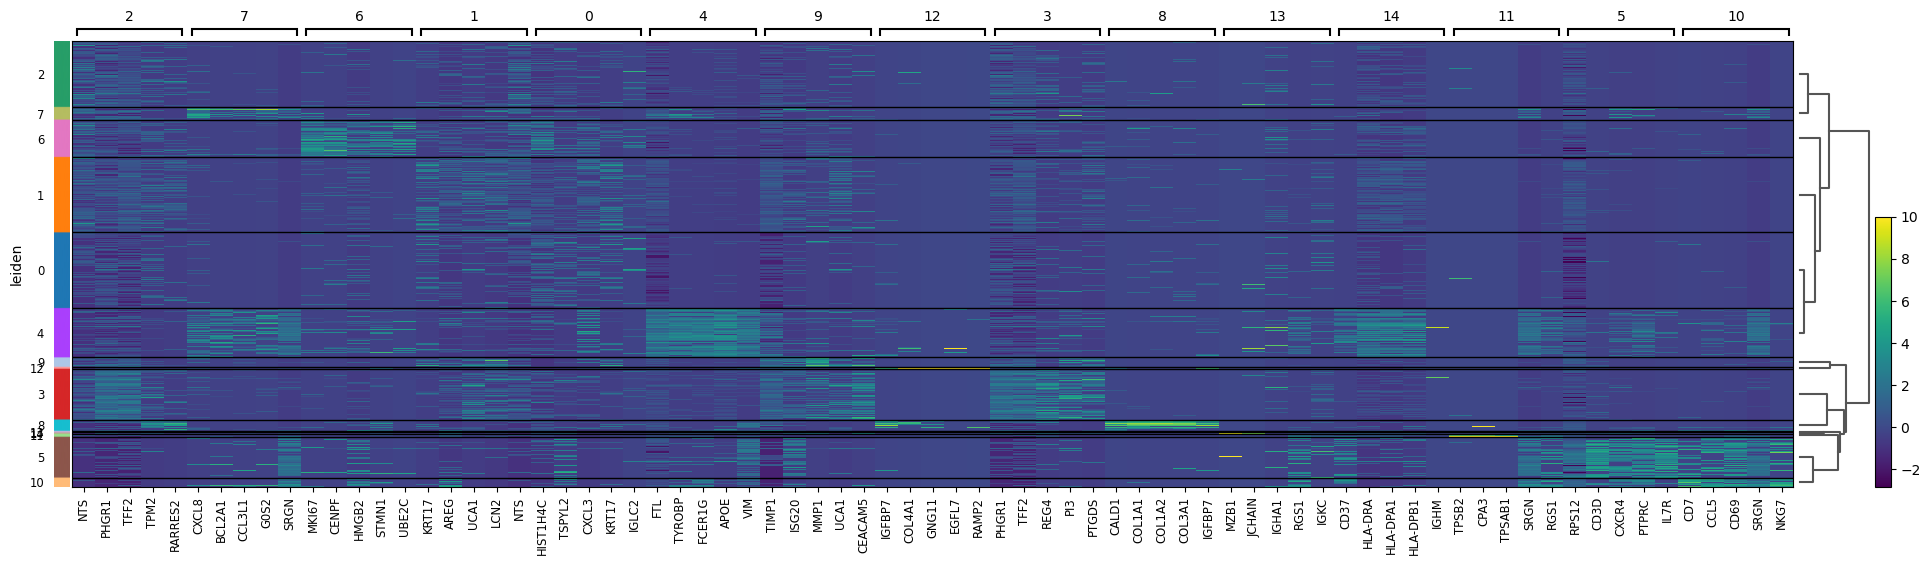

In [54]:
import scanpy as sc
import pandas as pd
import os

# 0) (Re)load your saved object
adata = sc.read_h5ad('results/combined_all_samples2.h5ad')

# 1) Stash the log‐normalized matrix so we can compute true fold‐changes
adata.raw = adata

# 2) Rank genes for each leiden cluster vs. all others
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    use_raw=True
)

# 3) View the top 5 markers for cluster “0”
df0 = sc.get.rank_genes_groups_df(adata, group='0')
print(df0.head(5))

# 4) DotPlot of the top 3 markers per cluster
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=3,
    groupby='leiden',
    standard_scale='var',
    dendrogram=True
)

# 5) Heatmap of the top 5 markers per cluster
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    groupby='leiden',
    show_gene_labels=True,
    dendrogram=True
)

# 6) Export all cluster markers to CSV
markers = sc.get.rank_genes_groups_df(adata, None)
os.makedirs('results', exist_ok=True)
markers.to_csv('results/cluster_markers_all.csv', index=False)


In [33]:
# rank genes for tissue comparison
sc.tl.rank_genes_groups(
    adata,
    groupby='tissue',
    reference='Metastasis',    # or 'Normal' if you add that sample later
    method='wilcoxon'
)

# View top 10 Tumor-enriched genes
print(sc.get.rank_genes_groups_df(adata, group='Tumor').head(10))


      names     scores  logfoldchanges          pvals      pvals_adj
0     KRT17  35.715916             NaN  2.238236e-279  1.041040e-277
1   RARRES2  26.394753             NaN  1.574057e-153  3.537206e-152
2      CTGF  25.224455             NaN  2.160137e-140  4.194441e-139
3       NTS  24.017960             NaN  1.805410e-127  3.223947e-126
4      TPM2  23.136444             NaN  1.990657e-118  3.263372e-117
5  HIST1H4C  20.186462             NaN   1.287589e-90   1.866071e-89
6     LTC4S  15.308033             NaN   6.757643e-53   7.508493e-52
7      INSR  15.239068             NaN   1.946261e-52   2.138749e-51
8      AQP1  13.285513             NaN   2.809266e-40   2.795289e-39
9    COL1A1  13.236451             NaN   5.404262e-40   5.350754e-39


In [64]:
# --- 0) (Re)load or pick up your processed AnnData ---
adata = sc.read_h5ad('results/combined_all_samples_scaled.h5ad')

# --- 1) Make sure your raw slot contains the full log1p matrix ---
#    (do this after your sc.pp.log1p but before any scaling/regression)
#    If you haven't already, you can still overwrite raw now:
adata.raw = adata  

# --- 2) (Re)run your DE for Tissue, using raw for FCs ---
sc.tl.rank_genes_groups(
    adata,
    groupby   = 'tissue',
    reference = 'Metastasis',
    method    = 'wilcoxon',
    use_raw   = True
)

# --- 3) Pull out the Tumor vs Met DE table correctly ---
#      Note: sc.get.rank_genes_groups_df takes only (adata, group)
df_tumor = sc.get.rank_genes_groups_df(adata, group='Tumor')

print(df_tumor[['names','logfoldchanges','pvals_adj']].head(10))


      names  logfoldchanges      pvals_adj
0     KRT17             NaN  1.041040e-277
1   RARRES2             NaN  3.537206e-152
2      CTGF             NaN  4.194441e-139
3       NTS             NaN  3.223947e-126
4      TPM2             NaN  3.263372e-117
5  HIST1H4C             NaN   1.866071e-89
6     LTC4S             NaN   7.508493e-52
7      INSR             NaN   2.138749e-51
8      AQP1             NaN   2.795164e-39
9    COL1A1             NaN   5.350754e-39


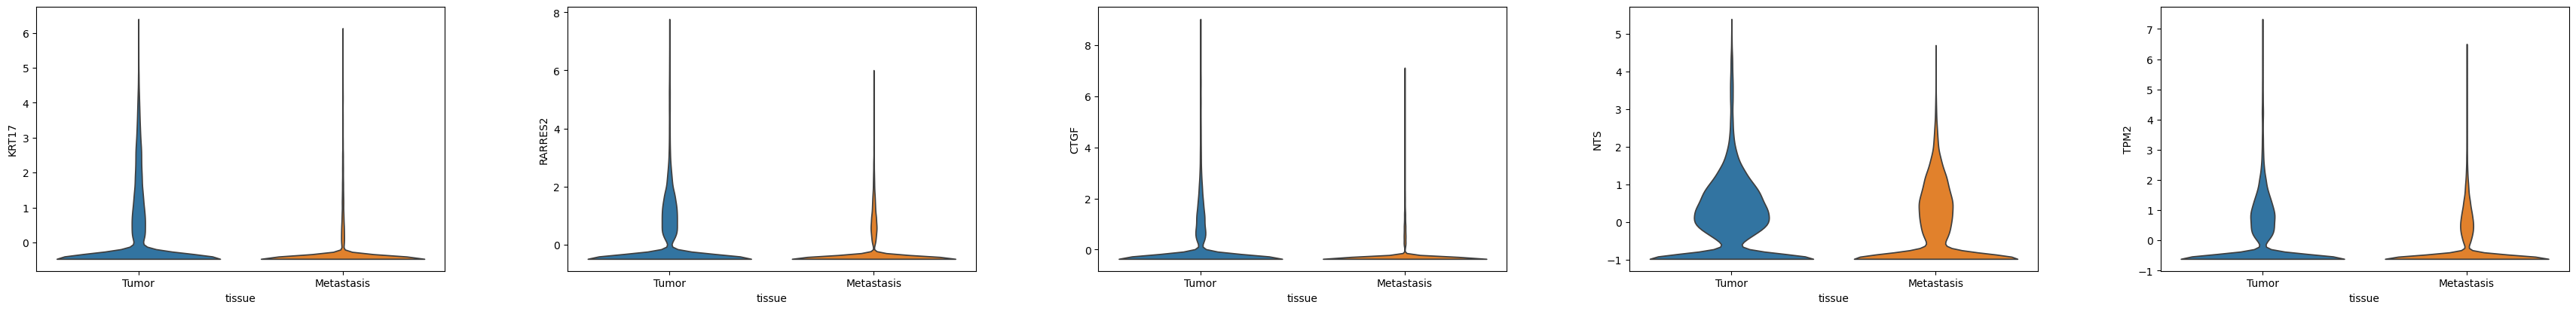

In [65]:
# violin of the top 5 Tumor genes
top5 = df_tumor['names'].values[:5]
sc.pl.violin(
    adata,
    keys      = top5,
    groupby   = 'tissue',
    stripplot = False,
    jitter    = False,
    multi_panel=True
)


In [66]:
sc.pl.rank_genes_groups_violin(
    adata,
    groups   = ['Tumor','Metastasis'],
    key      = 'rank_genes_groups',
    n_genes  = 5,
    stripplot=False
)


TypeError: rank_genes_groups_violin() got an unexpected keyword argument 'stripplot'